In [1]:
%matplotlib inline

In [76]:
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import PIL
import pdb
import sys
from datetime import datetime

In [30]:
# please install ffmpeg
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

In [36]:
df = pd.read_csv('data/votos_senado.csv')

In [37]:
df.loc[df['candidato_part'] == 'S/Partido', 'candidato_part'] = 'S.PART.'
df['candidato_part'].fillna('S.PART.', inplace=True)
df['candidato_uf'].fillna('', inplace=True)

In [38]:
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['ano'] = df['date'].apply(lambda x:x.year)

In [39]:
df.columns

Index(['candidato_id', 'candidato_name', 'candidato_part', 'candidato_uf',
       'date', 'proposition_id', 'proposition_name', 'sessao_desc',
       'sessao_id', 'voto', 'ano'],
      dtype='object')

In [93]:
def pca_over_year(year):
    v = pd.pivot_table(df[df['ano'] == year],
                       values='voto',index=['candidato_id', 'candidato_part'],
                       columns='proposition_id', fill_value=0)
    part = v.reset_index().drop('candidato_id', axis=1)
    part = part.groupby('candidato_part').mean()
    x, y = PCA(2).fit_transform(part).round(2).T
    return zip(part.index.tolist(), x, y)

In [41]:
def cvtcolor(path):
    PIL.Image.open(path).convert("RGBA").save(path)

In [42]:
def getImage(partido):
    p = partido.upper().replace(' ', '')
    try:
        path = glob.glob(f"../logos/{p}.*")[0]
    except Exception:
        print(p)
    img = PIL.Image.open(path)
    img.thumbnail((50, 50))
    return OffsetImage(img)

def spectre(year):
    fig, ax = plt.subplots(figsize=(20, 6))
    part, x, y, = pca_over_year(year)
    sns.scatterplot(-x, y, hue=part)
    for x0, y0, path in zip(-x, y, part):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

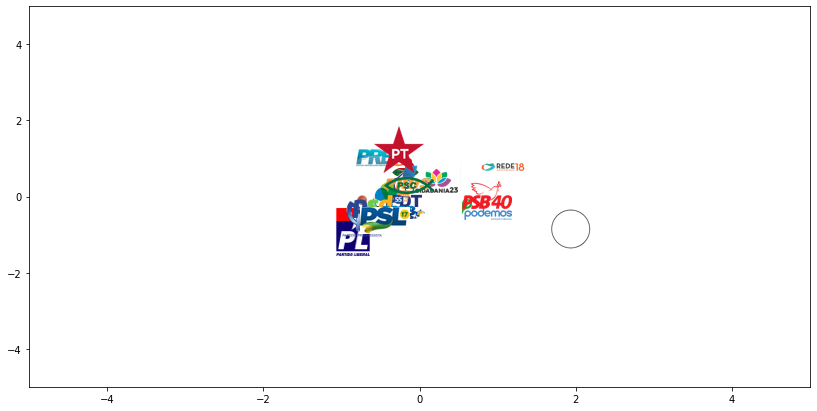

In [50]:
anos = df['ano'].value_counts().sort_index().index.tolist()

fig, ax = plt.subplots(figsize=(14, 7))
part, x, y = [], [], []
scat = ax.scatter([], [])

def init():
    return (scat,)

def animate(i):
    part, x, y, = pca_over_year(anos[i])
    data = np.array([x, y]).T
    
    ax.clear()
    ax.set(xlim=(-5, 5), ylim=(-5, 5))
    scat.set_offsets(data)
    for x0, y0, path in zip(x, y, part):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)
    return (scat,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(anos), interval=2000, blit=True)

HTML(anim.to_html5_video())

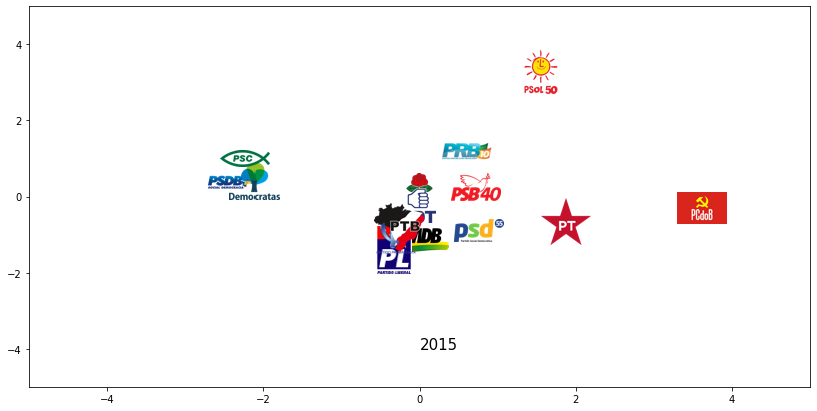

In [100]:
STEPS_PER_YEAR = 5
anos = df['ano'].value_counts().sort_index().index.tolist()

fig, ax = plt.subplots(figsize=(14, 7))
part, x, y = [], [], []
scat = ax.scatter([], [])

def init():
    return (scat,)

def generate_frame(STEPS_PER_YEAR):
    
    def get_dict(year):
        return {
            part: (x, y)
            for part, x, y in pca_over_year(year)
        }
    
    old_parties = get_dict(anos[0])
    for year in tqdm(anos[1:]):
        new_parties = get_dict(year)
        parties = {
            part: value
            for part, value in new_parties.items()
            if part in old_parties
        }
        for i in tqdm(range(STEPS_PER_YEAR), leave=False):
            rate = i / STEPS_PER_YEAR
            artists = []
            for part, (x, y) in parties.items():
                artists.append([
                    (1 - rate) * old_parties[part][0] + rate * x,
                    (1 - rate) * old_parties[part][1] + rate * y,
                    part,
                ])
            yield {
                'year': year,
                'artists': artists,
            }
        old_parties = new_parties
        # REMOVEME
        if year == anos[5]:
            break

def animate(frame):
    ax.clear()
    ax.set(xlim=(-5, 5), ylim=(-5, 5))
    for x0, y0, path in frame['artists']:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)
    ax.annotate(str(frame['year']), xy=(0, -4), xytext=(0, -4), size=15)
    return (scat,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=generate_frame(STEPS_PER_YEAR),
                               interval=5000/STEPS_PER_YEAR,
                               blit=True)

HTML(anim.to_html5_video())